In [98]:
#import bqplot
import datetime
import ee
import folium
import glob
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import os
import pandas as pd
import pprint
import pylab
import random
import seaborn as sns
import statsmodels.api as sm
import time

from collections import Counter
from imageio import imwrite
from IPython.display import display, IFrame, Image
from scipy.stats import normaltest, shapiro, anderson, skew
from skimage.viewer import ImageViewer
from skimage.io import imread
from sklearn.preprocessing import normalize, StandardScaler
from tqdm import tqdm, tnrange
from os import listdir

from cornacle_lib import *

#from matplotlib import gridspec
pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()

plt.rc('font', size= 12)
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize= 16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=12)

In [99]:
corn_grain = pd.read_csv('./data/corn-grain.csv')

corn_grain_2018 = corn_grain[corn_grain['YEAR'] == 2018]
corn_grain_2018 = corn_grain_2018.groupby('STATE').mean().reset_index()
corn_grain_2018[['STATE', 'YIELD_BU_ACRE']]
corn_grain_2018['STATE'] = [state[0:2] for state in corn_grain_2018['STATE']]
corn_grain_2018.shape

(32, 8)

NormaltestResult(statistic=array([487.08298294]), pvalue=array([1.70323331e-106]))

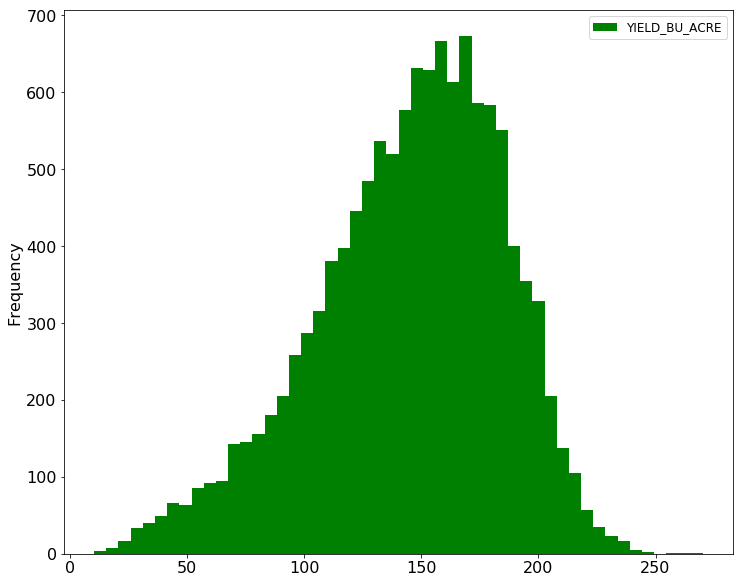

In [100]:
# Corn yields distribution across U.S.

corn_grain[['YIELD_BU_ACRE']].plot.hist(bins=50, color='g')
normaltest(corn_grain[['YIELD_BU_ACRE']].values.tolist())

In [116]:

# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it

county_geo = os.path.join('.', 'data/shapefiles', 'us-counties.json')
state_geo = os.path.join('.', 'data/shapefiles', 'us-states.json')

In [117]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
 
# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_unemployment = os.path.join('.', 'data', 'US_Unemployment_Oct2012.csv')

state_data = pd.read_csv(state_unemployment)
state_data.shape

FileNotFoundError: [Errno 2] File b'./data/US_Unemployment_Oct2012.csv' does not exist: b'./data/US_Unemployment_Oct2012.csv'

In [118]:
county_geo = 'data/shapefiles/us-counties.json'
os.path.isfile(county_geo)

True

In [119]:
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

In [120]:
states = pd.read_csv('data/states.csv')

In [123]:
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=county_geo,
 name='choropleth',
 data=corn_grain,
 columns=['COUNTY', 'YIELD_BU_ACRE'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Corn Yield (bu/acre)'
)
folium.LayerControl().add_to(m)
 
# Save to html
m.save('./web/corn_yield_state_map.html')

In [9]:
unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
unique_data[:8]

[[1, 1], [1, 3], [1, 5], [1, 9], [1, 11], [1, 13], [1, 15], [1, 19]]

In [10]:
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))

There are a total of 37 states with 2003 counties in the dataset.


In [11]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'],
              'MODIS/006/MYD11A2':[0,4],
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]
        }

folders = ['USDA_CROP',
           'MODIS_TEMP',
           'MODIS_LAND'
           ]

locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2011-1-2', '2019-7-4']
scale = 500 #meters/pixel
dates_of_images = {folder:[] for folder in folders} #initialize empty dictionary with folder names as keys

In [12]:
county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target])\
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
    
#     if False:
#         # Getting images
#         for i, (loc1, loc2) in enumerate(locations):

#             im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#             scale  = scale
#             crs = 'EPSG:4326'   # Coordinate Reference System

#             # filter for a county
#             region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#             region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#             region = ee.Feature(region.first()) # get the coordinates and other features

#             while True:
#                 try:
#                     export_image(img.clip(region), folder, im_name, scale, crs)
#                 except Exception:
#                     print(Exception)
#                     time.sleep(10)
#                     continue
#                 break
#             if (i%250 == 0) or (i == len(locations)-1):
#                 print(i)        


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  7
Dates available:  ['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31']
Band cropland will be downloaded in 7 images per county. ( 100.0 %)

 ######################### MODIS/006/MYD11A2 #########################
Total Dates Available:  319
Dates available:  ['2011-03-05', '2011-03-13', '2011-03-21', '2011-03-29', '2011-04-06', '2011-04-14', '2011-04-22', '2011-04-30', '2011-05-08', '2011-05-16', '2011-05-24', '2011-06-01', '2011-06-09', '2011-06-17', '2011-06-25', '2011-07-03', '2011-07-11', '2011-07-19', '2011-07-27', '2011-08-04', '2011-08-12', '2011-08-20', '2011-08-28', '2011-09-05', '2011-09-13', '2011-09-21', '2011-09-29', '2011-10-07', '2011-10-15', '2011-10-23', '2011-10-31', '2011-11-08', '2011-11-16', '2011-11-24', '2011-12-02', '2011-12-10', '2011-12-18', '2011-12-26', '2012-03-04', '2012-03-12', '2012-03-20', '2012-03-28', '2012-04-05', 

Band sur_refl_b01 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b02 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b03 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b04 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b05 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b06 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b07 will be downloaded in 319 images per county. ( 100.0 %)


In [13]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = scale   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))

Total Dates 319
There are 638 total number of images


In [14]:
#DO NOT DELETE THIS
# # Getting images
# for i, (loc1, loc2) in enumerate(locations):

#     im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#     scale  = scale
#     crs = 'EPSG:4326'   # Coordinate Reference System

#     # filter for a county
#     region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#     region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#     region = ee.Feature(region.first()) # get the coordinates and other features

#     while True:
#         try:
#             export_image(img.clip(region), folder, im_name, scale, crs)
#         except Exception:
#             print(Exception)
#             time.sleep(10)
#             continue
#         break
#     if (i%500 == 0) or (i == len(locations)-1):
#         print(i)

In [20]:
data_path = '/media/james/tbhdd/Google Drive/'
#data_path = '/home/james/ledermau@gmail.com/EarthEngine/'

USDA_CROP_path = data_path + 'USDA_CROP/'
USDA_MOISTURE_path = data_path + 'USDA_MOISTURE/'
MODIS_TEMP_path = data_path + 'MODIS_TEMP/'
MODIS_LAND_path = data_path + 'MODIS_LAND/'

folder_list = [USDA_CROP_path, USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_LAND_path]

for folder in folder_list:
    print("Files in {}: {}".format(folder, len(listdir(folder))))

Files in /media/james/tbhdd/Google Drive/USDA_CROP/: 2002
Files in /media/james/tbhdd/Google Drive/USDA_MOISTURE/: 2002
Files in /media/james/tbhdd/Google Drive/MODIS_TEMP/: 2002
Files in /media/james/tbhdd/Google Drive/MODIS_LAND/: 2002


In [21]:
#import matplotlib as plt
test_county = '19_57' #des moines
#path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_MOISTURE/USDA_MOISTURE_', 'USDA_CROP/USDA_CROP_']
path = ['USDA_CROP/USDA_CROP_', 'MODIS_LAND/MODIS_LAND_']

In [22]:
test = imread(USDA_CROP_path + listdir(USDA_CROP_path)[0])
file

NameError: name 'file' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

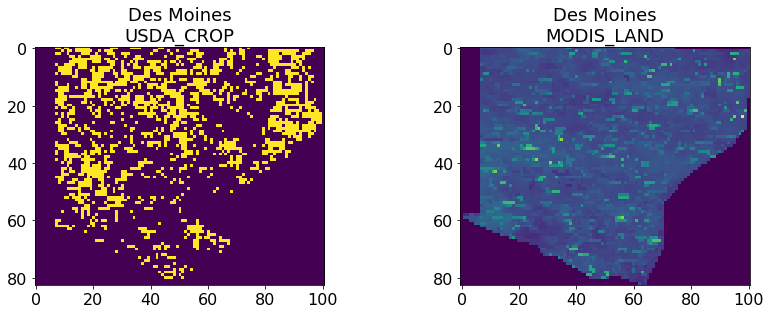

In [23]:
plt.rcParams['figure.figsize'] = [12, 8]
for i, file in enumerate(path):
    test = imread(data_path + file + test_county + '.tif')
    plt.subplot(2,2, i+1)
    plt.imshow(test[:, :, 0], )
    plt.title('Des Moines\n' + file.split('/')[1][:-1], fontsize=18)
    #plt.colorbar()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.savefig('Example Images', dpi=500)
plt.tight_layout(1.04)
plt.show

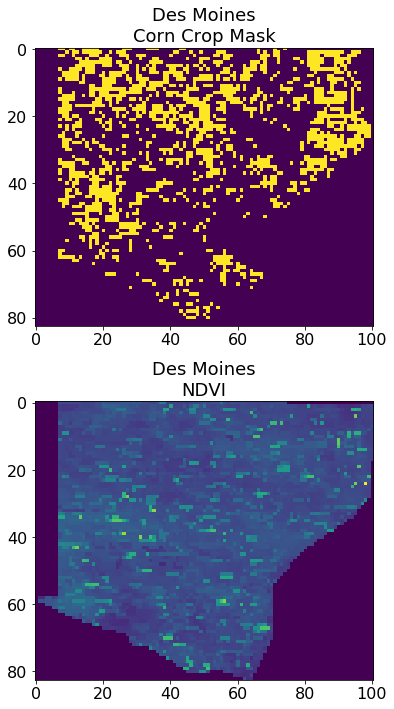

In [24]:
plt.rcParams['figure.figsize'] = [12, 10]
for i, file in enumerate(path):
    test = imread(data_path + file + test_county + '.tif')
    plt.subplot(2,1, i+1)
    plt.imshow(test[:, :, 0], )
    plt.title('Des Moines\n' + ['Corn Crop Mask', 'NDVI'][i], fontsize=18)
    #plt.colorbar()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.savefig('Example Images', dpi=500)
plt.tight_layout(1.04)
plt.show()

In [25]:
# Processing image (this one I didn't rerun cause it takes forever)

@nb.jit
def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_3 = zero_fill(img_3)

        if count_img_nan(img_3) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
                                              count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_3_list):
            for j in range(img_year.shape[2]):
                img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2010, 2017))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_3_list):
            np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = data_path
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
    nband = [1, 7, 2, 2]
    output_path = '/home/james/git/cornacle/data/preprocessed'
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)
    

  0%|          | 0/2001 [00:00<?, ?it/s]

266.0 266.0 318.0


ValueError: Dimension of the matrix is not correct.

In [26]:
path = data_path
folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
nband = [1, 7, 2, 2]
output_path = '/home/james/git/cornacle/data/temp/'
filedata = path, folder, nband, fips_data, dates_of_images
filedata

('/media/james/tbhdd/Google Drive/',
 ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE'],
 [1, 7, 2, 2],
 [[1, 1],
  [1, 3],
  [1, 5],
  [1, 9],
  [1, 11],
  [1, 13],
  [1, 15],
  [1, 19],
  [1, 21],
  [1, 29],
  [1, 31],
  [1, 33],
  [1, 35],
  [1, 39],
  [1, 41],
  [1, 43],
  [1, 45],
  [1, 47],
  [1, 49],
  [1, 51],
  [1, 53],
  [1, 55],
  [1, 57],
  [1, 59],
  [1, 61],
  [1, 63],
  [1, 65],
  [1, 67],
  [1, 69],
  [1, 71],
  [1, 75],
  [1, 77],
  [1, 79],
  [1, 83],
  [1, 87],
  [1, 89],
  [1, 91],
  [1, 95],
  [1, 97],
  [1, 99],
  [1, 101],
  [1, 103],
  [1, 105],
  [1, 107],
  [1, 109],
  [1, 111],
  [1, 113],
  [1, 117],
  [1, 119],
  [1, 121],
  [1, 123],
  [1, 125],
  [1, 127],
  [1, 129],
  [1, 131],
  [5, 1],
  [5, 3],
  [5, 17],
  [5, 21],
  [5, 29],
  [5, 31],
  [5, 33],
  [5, 35],
  [5, 37],
  [5, 41],
  [5, 43],
  [5, 45],
  [5, 47],
  [5, 55],
  [5, 63],
  [5, 67],
  [5, 69],
  [5, 71],
  [5, 73],
  [5, 75],
  [5, 77],
  [5, 79],
  [5, 83],
  [5, 85],
  [5, 91]

In [27]:
new_dates ={}
#tqdm(fips_data)
state, county = fips_data[1]
state, county

(1, 3)

In [28]:
imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
#mask = imread(path + folder[0] + '/' + imname_mask)
imname_mask
mask = imread(os.path.join('.', data_path, 'USDA_CROP', imname_mask))

In [29]:
mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
count_img_nan(mask)

0

In [30]:
imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif'
#print(imname_folder_1)
img_1 = imread(path + folder[1] + '/' + imname_folder_1)
#print(img_1)
img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])

In [31]:
img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]


In [32]:
output_path

'/home/james/git/cornacle/data/temp/'

In [33]:
folders


['USDA_CROP', 'MODIS_TEMP', 'MODIS_LAND']

In [34]:
year_list = list(range(2011, 2018))
for i, img_year in enumerate(img_1_list):
    np.save(os.path.join(output_path + folders[1] + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 

SyntaxError: unexpected EOF while parsing (<ipython-input-34-9917743deaf7>, line 3)

In [ ]:
# #Get specific missing images
# #folder = 'USDA_CROP'; target = 'USDA/NASS/CDL'
# folder = 'MODIS_TEMP'; target = 'MODIS/006/MYD11A2'
# #folder = 'MODIS_LAND'; target = 'MODIS/006/MOD09A1'

# loc1 = 1 #State FIPS
# loc2 = 5 #County FIPS


# county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

# if folder == 'USDA_CROP':
#     img_collection = ee.ImageCollection(target)\
#                     .filterDate(dates[0], dates[1])\
#                     .select(target_sat[target]) 
# else:
#     img_collection = ee.ImageCollection(target)\
#                     .filterDate(dates[0], dates[1])\
#                     .select(target_sat[target])\
#                     .filter(ee.Filter.calendarRange(3,12,'month'))

# # append bands to each image when collected
# img = img_collection.iterate(appendBand)
# if folder == 'USDA_CROP':
#     img = ee.Image(img).eq(1)  # only corn 
# else:
#     img = ee.Image(img)

# # print basic info (bands and no. of available images)
# dates_of_images[folder] += dates_available(img_collection)
# print('\n ######################### ' + target +  ' #########################')
# print("Total Dates Available: ", len(dates_of_images[folder]))
# print("Dates available: ", dates_of_images[folder])

# collection_bands = available_bands(img_collection)
# for k, v in collection_bands.items():
#     print("Band", k, "will be downloaded in", v['number_available'],
#           "images per county. (", v['percent_available'], "%)")

# im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
# scale  = scale
# crs = 'EPSG:4326'   # Coordinate Reference System

# # filter for a county
# region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
# region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
# region = ee.Feature(region.first()) # get the coordinates and other features

# # while True:
# #     try:
# #         export_image(img.clip(region), folder, im_name, scale, crs)
# #     except Exception:
# #         print(Exception)
# #         time.sleep(10)
# #         continue
# #     break        

In [35]:
folders

['USDA_CROP', 'MODIS_TEMP', 'MODIS_LAND']

In [37]:
fips_data

[[1, 1],
 [1, 3],
 [1, 5],
 [1, 9],
 [1, 11],
 [1, 13],
 [1, 15],
 [1, 19],
 [1, 21],
 [1, 29],
 [1, 31],
 [1, 33],
 [1, 35],
 [1, 39],
 [1, 41],
 [1, 43],
 [1, 45],
 [1, 47],
 [1, 49],
 [1, 51],
 [1, 53],
 [1, 55],
 [1, 57],
 [1, 59],
 [1, 61],
 [1, 63],
 [1, 65],
 [1, 67],
 [1, 69],
 [1, 71],
 [1, 75],
 [1, 77],
 [1, 79],
 [1, 83],
 [1, 87],
 [1, 89],
 [1, 91],
 [1, 95],
 [1, 97],
 [1, 99],
 [1, 101],
 [1, 103],
 [1, 105],
 [1, 107],
 [1, 109],
 [1, 111],
 [1, 113],
 [1, 117],
 [1, 119],
 [1, 121],
 [1, 123],
 [1, 125],
 [1, 127],
 [1, 129],
 [1, 131],
 [5, 1],
 [5, 3],
 [5, 17],
 [5, 21],
 [5, 29],
 [5, 31],
 [5, 33],
 [5, 35],
 [5, 37],
 [5, 41],
 [5, 43],
 [5, 45],
 [5, 47],
 [5, 55],
 [5, 63],
 [5, 67],
 [5, 69],
 [5, 71],
 [5, 73],
 [5, 75],
 [5, 77],
 [5, 79],
 [5, 83],
 [5, 85],
 [5, 91],
 [5, 93],
 [5, 95],
 [5, 107],
 [5, 111],
 [5, 117],
 [5, 119],
 [5, 121],
 [5, 123],
 [5, 145],
 [5, 147],
 [5, 149],
 [6, 7],
 [6, 11],
 [6, 19],
 [6, 21],
 [6, 29],
 [6, 31],
 [6, 47],
 [6

In [36]:
mask = folders[0] + '_' + str(state) + '_' + str(county) + '.tif'
missing = []
for folder in folders:
    for state, county in tqdm(fips_data):
        imname = folder + '_' + str(state) + '_' + str(county) + '.tif'
        img_fullpath = "{}{}/{}".format(path, folder, imname)
        if imname not in os.listdir(path + folder):
            print("Image not found: {}".format(img_fullpath))
            missing.append(img_fullpath)

100%|██████████| 2001/2001 [00:03<00:00, 584.97it/s]


In [39]:
#Iowa only
fips_data_test = [row for row in fips_data if row[0] == 19]

In [41]:
# Processing images
#LEAVING OUT MOISTURE FOR NOW
@nb.jit
def image_processing_I(filedata):
    path, folders, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        #imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures       
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        #img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]): #or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2])#, img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        #img_3 = zero_fill(img_3)

        #if count_img_nan(img_3) > 0:
        #    print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
        #    in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
         #                                     count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        #img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        #for i, img_year in enumerate(img_3_list):
        #    for j in range(img_year.shape[2]):
        #        img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2011, 2018))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        #for i, img_year in enumerate(img_3_list):
        #    np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = data_path
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP']#, 'USDA_MOISTURE']
    nband = [1, 7, 2]#, 2]
    output_path = '/home/james/git/cornacle/data/temp/'
    filedata = path, folders, nband, fips_data_test, dates_of_images
    
    image_processing_I(filedata)

100%|██████████| 99/99 [03:46<00:00,  2.35s/it]


#### Original

In [ ]:
#ORIGINAL

# # Processing image (this one I didn't rerun cause it takes forever)

# @nb.jit
# def image_processing_I(filedata):
#     path, folder, nband, fips_data, dates_of_images = filedata
#     new_dates = {}
#     for state, county in tqdm(fips_data):
#         # Create path
#         imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
#         imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
#         imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
#         imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

#         # Reading figures
#         mask = imread(path + folder[0] + '/' + imname_mask)
#         img_1 = imread(path + folder[1] + '/' + imname_folder_1)
#         img_2 = imread(path + folder[2] + '/' + imname_folder_2)
#         img_3 = imread(path + folder[3] + '/' + imname_folder_3)

#         # Lets do just 2010-2016 first
#         mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
#         img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
#         img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

#         # Making sure the bands of the figure are correct
#         if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
#         or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
#             print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
#             raise ValueError('Dimension of the matrix is not correct.')

#         # Zero fill NaN
#         img_3 = zero_fill(img_3)

#         if count_img_nan(img_3) > 0:
#             print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
#             in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
#                                               count_img_nan(mask), state, county))

#         # Splitting images by year
#         img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
#         img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
#         img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

#         # Masking
#         for i, img_year in enumerate(img_1_list):
#             for j in range(img_year.shape[2]):
#                 img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
#         for i, img_year in enumerate(img_2_list):
#             for j in range(img_year.shape[2]):
#                 img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
#         for i, img_year in enumerate(img_3_list):
#             for j in range(img_year.shape[2]):
#                 img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
#         year_list = list(range(2011, 2018))
#         # export images, this part can be improved by using HDF5
#         for i, img_year in enumerate(img_1_list):
#             np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
#         for i, img_year in enumerate(img_2_list):
#             np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
#         for i, img_year in enumerate(img_3_list):
#             np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
# if __name__ == "__main__":
#     path = data_path
#     folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
#     nband = [1, 7, 2, 2]
#     output_path = '/home/james/git/cornacle/data/temp'
#     filedata = path, folder, nband, fips_data, dates_of_images
    
#     image_processing_I(filedata)

In [ ]:
# #ORIGINAL
# # Plotting distribution of band values in 3000 images

# plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 3000, corn_grain)
# plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 3000, corn_grain)
# plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 3000, corn_grain)

# cm = pylab.get_cmap('viridis')
# band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
#              'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
#              'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
# nband = [7, 2, 2]
# plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP, plt_USDA_MOISTURE]
# xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

# f, axs = plt.subplots(1, 3, figsize=(25,6))

# for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
#     cm = pylab.get_cmap('magma')
    
#     for band in range(nband[i]):
#         color = cm(1.*band/nband[i])
#         _, p = normaltest(plt_file[band])
#         sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
#                      kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
#     axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
#     axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
# plt.tight_layout()
# plt.savefig('band distribution', dpi=500)
# plt.show()

In [42]:
data_out_path = '/home/james/git/cornacle/data/temp/'

In [43]:
listdir(data_out_path)

['MODIS_TEMP', 'MODIS_LAND']

In [47]:
#plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 3000, corn_grain)
#plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 3000, corn_grain)
#plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 3000, corn_grain)
file_dir = '/home/james/git/cornacle/data/temp/MODIS_LAND/'
nband = 7
nsample = 3000
yield_dataframe = corn_grain

#def plt_img_dist(file_dir, nband, nsample, yield_dataframe):
#    import random
#    """
#    Return data for plotting the distribution of the number in each band of a set of images in a folder.
#    Image is in a form of npy format. 
#    """
    
fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values

In [49]:
file_dir = data_out_path + 'MODIS_LAND/'
i = 0
fips[i][0]

2018

In [50]:
fips = [row for row in fips if row[0] !=2018]

In [53]:
test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')

# Plotting distribution of band values in 3000 images

plt_MODIS_LAND = plt_img_dist(data_out_path + 'MODIS_LAND', 7, 3000, corn_grain)
plt_MODIS_TEMP = plt_img_dist(data_out_path + 'MODIS_TEMP', 2, 3000, corn_grain)

100%|██████████| 3000/3000 [00:00<00:00, 57336.31it/s]


In [54]:
plt_MODIS_LAND

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}

In [55]:
data_out_path

'/home/james/git/cornacle/data/temp/'

In [56]:
file_dir

'/home/james/git/cornacle/data/temp/MODIS_LAND/'

In [57]:
fips = [row for row in fips if row[0] <2018]

In [58]:
fips = np.array(fips)

In [59]:
rand_idx = random.sample(range(0, len(fips)), nsample)
rand_idx

[10374,
 10489,
 10046,
 6412,
 5916,
 3269,
 6004,
 8457,
 5456,
 10713,
 8686,
 5178,
 662,
 4996,
 1719,
 8388,
 8033,
 10544,
 8877,
 3931,
 1995,
 9296,
 5479,
 8024,
 4096,
 2144,
 9085,
 4195,
 5160,
 3885,
 186,
 8975,
 911,
 10009,
 9467,
 5582,
 6759,
 4727,
 10353,
 4972,
 1298,
 1420,
 1978,
 6919,
 10792,
 6392,
 3450,
 6451,
 6398,
 3537,
 6510,
 2463,
 10263,
 7099,
 6545,
 7054,
 9277,
 8942,
 8031,
 2064,
 5957,
 1455,
 10558,
 2310,
 9435,
 6699,
 4656,
 6840,
 3489,
 15,
 10160,
 8879,
 9271,
 2097,
 591,
 2257,
 1457,
 6954,
 2251,
 4472,
 4864,
 3824,
 7979,
 3741,
 1914,
 8930,
 7813,
 7683,
 2028,
 8572,
 6212,
 3679,
 2561,
 1398,
 1054,
 548,
 10675,
 1634,
 8831,
 2537,
 9139,
 269,
 8788,
 10697,
 8211,
 4210,
 10162,
 1596,
 6345,
 3904,
 3405,
 4183,
 8601,
 3631,
 8634,
 7289,
 1070,
 1327,
 855,
 10814,
 6548,
 8270,
 6879,
 8755,
 7393,
 3822,
 4640,
 4906,
 297,
 4968,
 9625,
 2265,
 710,
 5317,
 10170,
 1166,
 1161,
 8424,
 4221,
 4872,
 9910,
 4296,
 

In [60]:
fips[rand_idx]

array([[2011,   39,   33],
       [2011,   42,   57],
       [2011,   29,  129],
       ...,
       [2013,   51,  139],
       [2014,   28,   87],
       [2012,   42,   17]])

In [61]:
data = {band:[] for band in range(0, nband)}

In [62]:
str(fips[i][0])

'2017'

In [64]:
for i in tqdm(fips[rand_idx]):
#file = random.choice(os.listdir("D://projectII_temp_data//MODIS_LAND"))
    try:
        test = np.load(file_dir + str(i[0]) + '_' + str(i[1]) + '_' + str(i[2]) + '.npy')
        for band in range(nband):
                data[band] = np.append(data[band], test[:, :, band].ravel())
                data[band] = data[band][np.nonzero(data[band])]
    except: # In case it hits [51,131] or [46, 102]
        pass

    
    # return data

100%|██████████| 3000/3000 [00:15<00:00, 188.45it/s]


In [71]:
files = listdir(file_dir)
test = np.load(file_dir+files[7])
test.shape
listdir(file_dir)
files = listdir(path)    
#    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values

#rand_idx = random.sample(range(len(files)), nsample)
len(files)

29

  0%|          | 0/1575 [00:00<?, ?it/s]


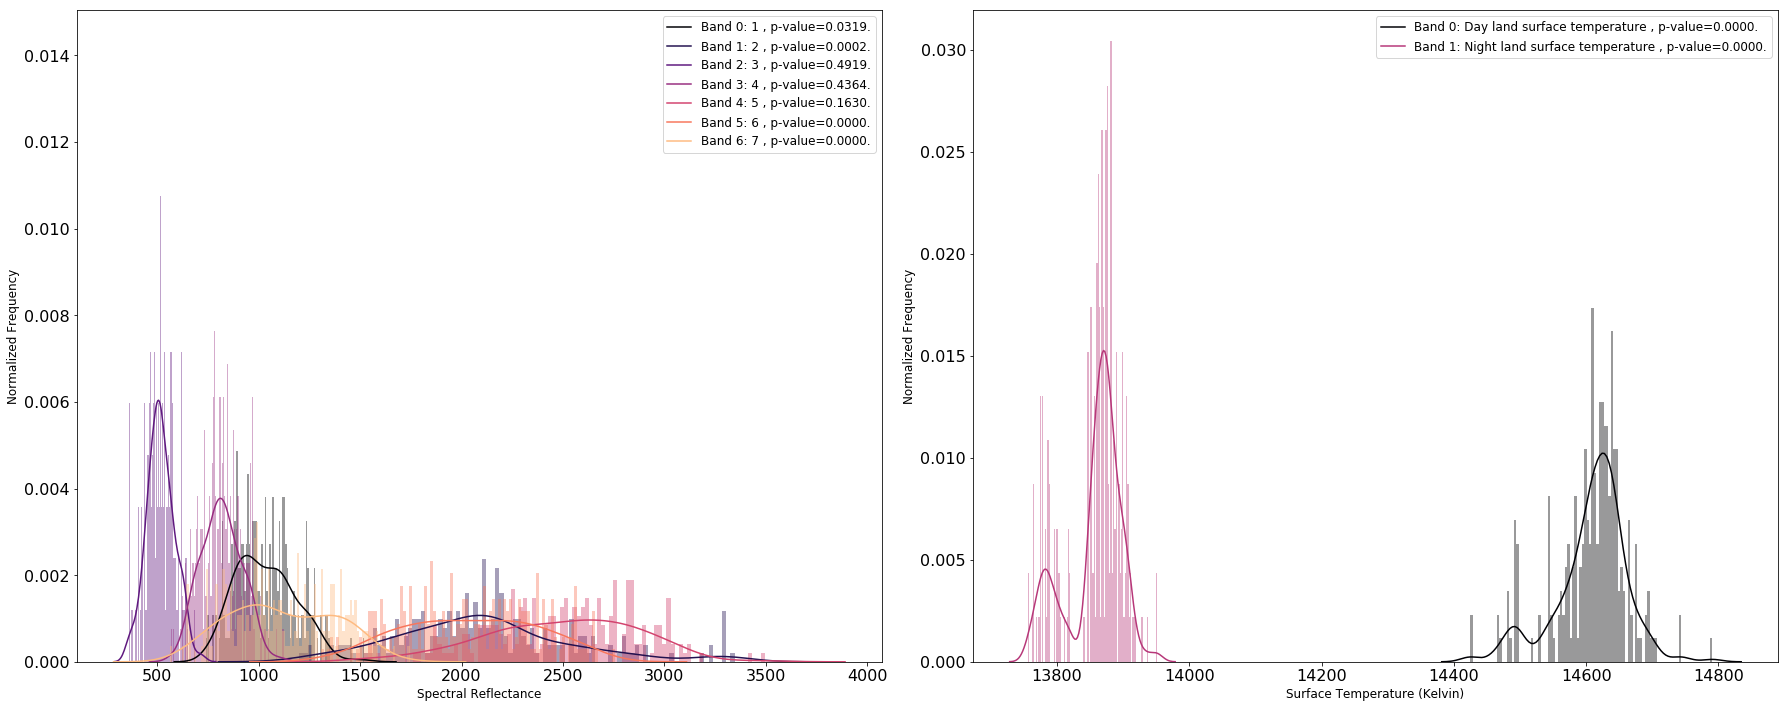

In [73]:
def plt_img_dist(path, nband, yield_dataframe):
#    """
#    Return data for plotting the distribution of the number in each band of a set of images in a folder.
 #   Image is in a form of npy format. 
  #  """
    files = listdir(path)    

    data = {band:[] for band in range(0, nband)}
    for filename in tqdm(files):
        try:
            test = np.load(path + filename)
            for band in range(nband):
                    data[band] = np.append(data[band], test[:, :, band].ravel())
                    data[band] = data[band][np.nonzero(data[band])]
        except:
            pass

        return data
################
plt_MODIS_LAND = plt_img_dist('/home/james/git/cornacle/data/temp/MODIS_LAND/', 7, corn_grain)
plt_MODIS_TEMP = plt_img_dist('/home/james/git/cornacle/data/temp/MODIS_TEMP/', 2, corn_grain)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature']}
             #,
             #'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2]#, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP]#, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)']#, 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 2, figsize=(25,10))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=12)
    axs[i].set_ylabel('Normalized Frequency', fontsize=12)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [74]:
def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total



path = '/home/james/git/cornacle/data/temp/MODIS_LAND/'
avg_year_LAND, count_year_LAND, max_year_LAND, yield_LAND, avg_total_LAND, std_total_LAND = \
get_stats(path, 7, len(listdir(path)), corn_grain)

path = '/home/james/git/cornacle/data/temp/MODIS_TEMP/'
avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats(path, 2, len(listdir(path)), corn_grain)

#avg_year_MOISTURE, count_year_MOISTURE, max_year_MOISTURE, yield_MOISTURE, avg_total_MOISTURE, std_total_MOISTURE =\
#get_stats('D://projectII_temp_data//USDA_MOISTURE//', 2, nsample, corn_grain)

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
